### 선형회귀

In [1]:
# 회귀모델은 RMSE를 최소화하는 방향으로 훈련해야 함

In [2]:
# 해석적인 방법 
# 정규 방정식

In [49]:
import numpy as np

X = 2* np.random.rand(100, 1)
y = 4+3*X + np.random.rand(100,1)

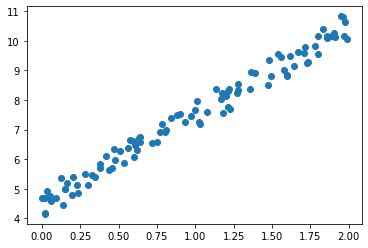

In [50]:
import matplotlib.pyplot as plt
plt.scatter(X, y)

In [51]:
X_b = np.c_[np.ones((100,1)), X] # 모든 샘플에 X0 = 1을 추가
theta_best = np.linalg.inv(X_b.T@X_b)@X_b.T@y

In [52]:
theta_best # 4, 3을 근접하게 예측

array([[4.54294458],
       [2.98057019]])

In [53]:
X_new = np.array([[0],[2]])
X_new_b = np.c_[np.ones((2,1)), X_new]
y_predict = X_new_b@theta_best
y_predict

array([[ 4.54294458],
       [10.50408495]])

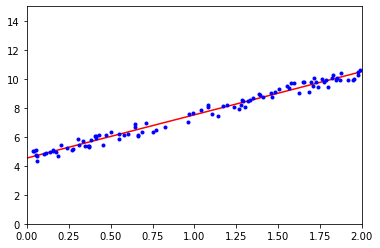

In [11]:
plt.plot(X_new, y_predict, 'r-')
plt.plot(X,y,'b.')
plt.axis([0,2,0,15])
plt.show()

In [16]:
# sklearn으로 선형 회귀 구현
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X, y)
# sklearn의 linearregression은 intercept(편향)와 coef(가중치)를 분리하여 저장함
lin_reg.intercept_, lin_reg.coef_

(array([4.46840485]), array([[3.02575709]]))

In [17]:
lin_reg.predict(X_new)

array([[ 4.46840485],
       [10.51991904]])

In [18]:
# sklearn의 linearregression은 유사역행렬로 계산 이는 특잇값 분해(SVD) 방식으로 작동됨
# 어떤 특성이 중복되어 역행렬이 없더라도 작동이 가능하다는 장점
# 계산 복잡도도 기존 정규방적식(O(N**2.4~3))에서  O(N**2)으로 감소하는 효과가 있음

### 경사하강법

- 무작위 초기화(random initialization)진행
- 학습률(learning rate)만큼 gradient를 감소하는 방향으로 이동, 최솟값까지 반복
- 지역최솟값에 수렴해, 전역최솟값을 반영하지 못할 수 있음
- 하지만 선형 회귀는 볼록함수(convex function)으로 지역최솟값 == 전역최솟값임
- 특성스케일을 통해(ex StandardScaler)를 통해 훈련시간을 줄여줄 수 있음 p168그림참조

- 배치 경사하강법

In [54]:
eta = 0.3 # 학습률
n_iterations = 1000
m = 100 # 샘플 수

theta = np.random.randn(2,1) # 무작위 초기화

for iteration in range(n_iterations):
    gradients = 2 / m * X_b.T@(X_b.dot(theta) -y)
    theta = theta - eta * gradients

In [55]:
theta

array([[4.54294458],
       [2.98057019]])

- 확률적 경사하강법
  - 빠르지만, 전역 최솟값을 찾아낼 확률이 배치경사보다 높음
  - 안정성이 떨어지므로, 담금질기법(simulated annealing) 알고리즘과 유사한 방법 사용
  - 처음엔 큰 학습률을 잉용하다 점차 작게 줄여서 최솟값에 도달하게 하는 것
  - 여기서 학습률을 결정하는 함수를 학습스케줄(learning schedule)이라고 함

In [59]:
n_epochs = 50
t0, t1 = 5, 50 #학습 스케줄 하이퍼 파라미터

def learning_schedule(t):
    return t0 / (t + t1)

theta = np.random.randn(2, 1)

for epoch in range(n_epochs):
    for i in range(m):
        random_index = np.random.randint(m)
        xi = X_b[random_index : random_index + 1]
        yi = y[random_index : random_index + 1]
        gradients = 2*xi.T@(xi@theta - yi)
        eta = learning_schedule(epoch *m +i)
        theta = theta - eta * gradients

In [60]:
theta

array([[4.54349514],
       [2.97964217]])

- 배치 경사 하강법이 전체 훈련 세트에 대해 1000번 반복하는 동안
- 확률적 경사 하강법은 훈련세트에서 50번 반복하고도 좋은 결과를 보여줌

- 주의점.
  - 확률적 경사 하강법에서 훈련샘플이 IID(Independent, and identically distribute)를 만족해야함
  - 이렇게 만들기 위해서는 각 샘플을 랜덤하게 선택하거나, 에포크를 시작할 때 훈련세트를 셔플해주는 방법 등이 있음

In [62]:
# SGDRegessor로 선형회귀 사용
# 다음 코드에서는 최대 1000번의 에포크
# 한 에포크에서 0.001보다 손실이 적을 때까지 실행
# 학습률 = 0.1
# 학습 스케줄은 기존과는 다름(p175 주석)

from sklearn.linear_model import SGDRegressor
sgd_reg = SGDRegressor(max_iter = 1000, tol=1e-3, penalty=None, eta0=0.1)
sgd_reg.fit(X, y.ravel())

SGDRegressor(eta0=0.1, penalty=None)

In [64]:
sgd_reg.intercept_, sgd_reg.coef_

(array([4.52816378]), array([2.99179642]))

- 미니배치 경사 하강법
  - 미니배치라 부르는 임의의 작은 샘플 세트에 대해 그레디언트를 계산
  - 확률적 경사하강과 비교하자면, 행렬 연산에 최적화된 하드웨어, 특히 GPU를 사용해 성능 향상을 이뤄냄
  - 미니배치가 SGD보다 최솟값에 더 가까이 도달할 가능성이 높지만, 지역최솟값에서는 더 빠져나오기 힘듦
  - 파라미터 공간에서 SGD보다 더 불규칙적으로 움직이기때문

### 다항회귀

In [66]:
m = 100
X = 6 * np.random.rand(m, 1)-3
y = 0.5 *X**2 + X + 2 + np.random.randn(m, 1)

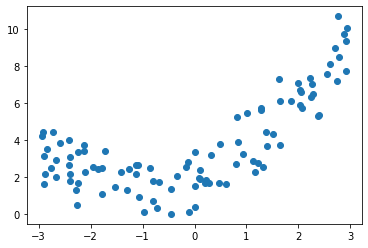

In [68]:
plt.scatter(X, y)

In [69]:
# 직선 형태의 단항회귀분석 수행이 불가능함

In [71]:
# PolynomialFeatures를 사용해서 훈련데이터 변환 => 훈련세트에 있는 각 특성을 제곱하여 새로운 특성으로 추가
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(2, include_bias=False)
X_poly = poly_features.fit_transform(X)
print(X[0])
print(X_poly[0])

[2.77891926]
[2.77891926 7.72239224]


In [72]:
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
lin_reg.intercept_, lin_reg.coef_

(array([2.04365473]), array([[0.97226646, 0.50415331]]))

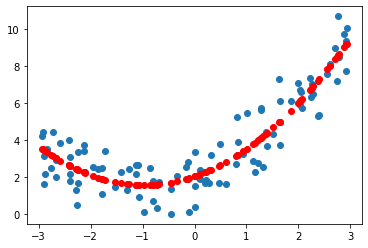

In [82]:
plt.scatter(X, y)
plt.scatter(X, lin_reg.predict(X_poly), c='r')

### 학습 곡선

- 앞서, 2차 다항 회귀로 분석함
- 고차 다항 회귀로 갈 수록 과적합 상태에 놓일 수 있음
- 어떻게 n차 곡선임을 확인하나?
- ==> 학습곡선을 통해
  - 훈련 세트와 검정 세트의 모델 성능을 훈련 세트 크기의 함수로 나타내는 것

In [85]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def plot_learning_curve(model, x, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
    train_errors, val_errors = [], []
    for m in range(1, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))
    plt.plot(np.sqrt(train_errors), 'r-+', linewidth=2, label='Train SET')
    plt.plot(np.sqrt(val_errors), 'b-', linewidth=2, label='Test SET')

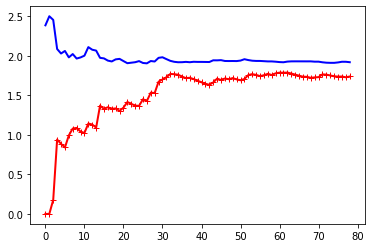

In [88]:
lin_reg = LinearRegression()
plot_learning_curve(lin_reg, X, y)
# y축 rmse, x축 훈련세트 크기

In [89]:
# 과소적합됐음을 보여줌 = 두 곡선이 수평한 구간을 만들고 꽤 높은 오차에서 매우 가까이 근접해있음
# 모델이 훈련 데이터에 과소적합되어 있다면 훈련 샘플을 더 추가해도 효과가 없음
# => 더 복잡한 모델을 사용하거나, 더 나은 특성을 선택해야 함

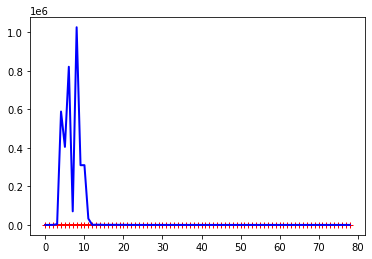

In [98]:
from sklearn.pipeline import Pipeline
polynomial_regression = Pipeline([
    ('poly_features', PolynomialFeatures(10, include_bias=False)),
    ('lin_reg', LinearRegression())
])
plot_learning_curve(polynomial_regression, X, y)

In [99]:
# 10차 회귀의 경우 과적합됐음을 알 수 있음
# 오차가 위 모델보다 현저히 작은 것을 알 수 있음
# => 과적합 모델을 개선하기 위해선 검증오차가 훈련오차에 근접할 때까지 더 많은 훈련데이터를 추가하는 것임

### 규제가 있는 선형모델

- 모델의 과적합을 감소시키는 방법으로 규제를 둘 수 있음
- 간단한 예시로는 다항 회귀 모델에서 다항식의 차수를 감소시키는 것

#### 릿지(ridge) 회귀

- 규제항이 비용함수에 추가됨
- 모델의 가중치가 가능한 작게 유지되도록 함
- 훈련이 끝나면 모델의 성을을 규제가 없는 성능지표로 평가함
- l2 노름을 사용 : 가중치 절대값의 제곱
- 규제항의 alpha가 커질수록 직선에 가까워짐 즉, 모델의 분산은 줄어들지만 편향은 커지게 됨

In [100]:
# sklearn의 정규방적식을 이용해 ridge에 적용하기
from sklearn.linear_model import Ridge
ridge_reg = Ridge(alpha=1, solver='cholesky')
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([[5.13984161]])

In [101]:
# 확률적 경사하강법
sgd_reg = SGDRegressor(penalty='l2')
sgd_reg.fit(X,y.ravel())
sgd_reg.predict([[1.5]])

array([5.12767898])

### 라쏘(lasso) 회귀
- 릿지와 비슷하지만, 가중치 벡터의 l1노름을 사용함 : 가중치 절대값